<table><tr> <th colspan="2" bgcolor="PowderBlue" style="text-align: center;">导入库</th></tr>
<tr><td>numpy</td><td>科学计算、向上取整、生成随机数、创建0矩阵、限制范围</td></tr>
<tr><td>scipy.stats</td><td>norm处理正态分布，binorm处理二项分布</td></tr>
<tr><td>pandas</td><td>存储数据表格</td></tr>
<tr><td>random</td><td>产生随机数、随机选择</td></tr>
<tr><td>math</td><td>数学计算</td></tr>
<tr><td>matplotlib.pyplot</td><td>绘制图形</td></tr>
</table>


In [1]:
import numpy as np
from scipy.stats import norm, binom
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']#设置中文字体为黑体

# 1️⃣Problem1
**目标**：
指定抽样检测方案，使得：  
1. 在标称值为10%的次品率、95%和90%的信度，**最小化**检测次数和检测成本。
2. 抽样检测，判断生产批次是否符合质量标准，具体是判断次品率**是否超过标称值（10%）**。
3. 判断拒绝/接收
   
**方法**：
<font color=Navy size=5>假设检验</font>

## 假设  
1. 在<font color="MediumSlateBlue">95%</font>的信度下认定零配件不合格率超过标称值($\pi$)，则**拒收**。  
原假设（H0）：零配件的次品率不超过标称值$\pi \le \pi_{0}$  
备择假设（H1）：零配件的次品率超过标称值$\pi > \pi_{0}$  

2. 在<font color="MediumSlateBlue">90%</font>的信度下认定零配件不合格率**不**超过标称值($\pi$)，则**接收**。  
原假设（H0）：零配件的次品率超过标称值$\pi \ge \pi_{0}$  
备择假设（H1）：零配件的次品率不超过标称值$\pi < \pi_{0}$

## 计算样本量
$n = \frac{Z_{\alpha/2} ^2 \cdot \pi_{0} \cdot (1 - \pi )}{E^2} $

### 定义计算样本量函数

In [2]:
#定义计算样本量函数
def calculate_sample_size(p0, alpha, delta):
    z_alpha_over_2 = norm.ppf(1 - alpha / 2)# 计算分位数Z: norm.ppf(p) 计算给定概率 p 的分位数。
    n = (z_alpha_over_2 ** 2 * p0 * (1 - p0)) / (delta ** 2)# n公式
    return int(np.ceil(n))# 样本量取圆整（向上取整）:ceil(3.2)->4.0,int(4.0)->4

### 定义右侧检验的函数
用于假设1 <font color="MediumSlateBlue">95%</font>

In [3]:
# 用于寻找右侧检验的函数
def find_right_side_threshold(n, p0, alpha):
    for d in range(n + 1):
        p_value = 1 - binom.cdf(d - 1, n, p0)
        if p_value <= alpha:
            return d
    return n

### 定义左侧检验的函数
用于假设2 <font color="MediumSlateBlue">90%</font>

In [4]:
# 用于寻找左侧检验的函数
def find_left_side_threshold(n, p0, alpha):
    for d in range(n + 1):# 0 ~ n：实验总次数
        p_value = binom.cdf(d, n, p0)# 计算p值，binom.cdf(d, n, p0) 计算在 n 次实验中成功次数小于或等于 d 的概率。
        if p_value >= 1 - alpha:
            return d
    return n

### 设定参数

In [5]:
p0 = 0.10 # 标称次品率pi

alpha_95 = 0.05 # 95%置信水平对应的alpha值（置信度、显著性水平，拒绝H0原假设的概率）
alpha_90 = 0.10 # 90%置信水平对应的alpha值

deltas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06] # 估计误差E列表

results = []# 初始化结果为空

### 计算95%/90%样本量，计算右侧检验95%次品数阈值、左侧检验90%次品数阈值并存为csv表格
抽取的样本中发现的次品数量落在拒绝域阈值右侧（95%）/左侧（90%），则可以拒绝该批次产品，认为它不符合质量标准。

In [6]:
for delta in deltas:
    # 计算情形 (1)95% 的样本量和次品数阈值
    n_95 = calculate_sample_size(p0, alpha_95, delta)
    d_95 = find_right_side_threshold(n_95, p0, alpha_95)

    # 计算情形 (2)90% 的样本量和次品数阈值
    n_90 = calculate_sample_size(p0, alpha_90, delta)
    d_90 = find_left_side_threshold(n_90, p0, alpha_90)

    results.append({
        'Delta': delta,
        'Sample Size (95%)': n_95,#计算出的样本量
        'Min Defects (95%)': d_95,#左侧检验95%次品数阈值，在样本量 n_95 下，能够接受的最小次品数
        'Sample Size (90%)': n_90,
        'Max Defects (90%)': d_90#右侧检验90%次品数阈值，在样本量 n_90 下，能够接受的最大次品数
    })

df = pd.DataFrame(results)#[{列名1:列1数据,列名2:列1数据……},{第2行}],默认第一列为index(第一行省略名称）从0开始

print(df)
df.to_csv('results1.csv', index=False)

   Delta  Sample Size (95%)  Min Defects (95%)  Sample Size (90%)  \
0   0.01               3458                376               2435   
1   0.02                865                102                609   
2   0.03                385                 49                271   
3   0.04                217                 30                153   
4   0.05                139                 21                 98   
5   0.06                 97                 16                 68   

   Max Defects (90%)  
0                263  
1                 70  
2                 34  
3                 20  
4                 14  
5                 10  


### 可视化次品数阈值
<font color="red">红</font>为95%  
<font color="blue">蓝</font>为90%  
纵坐标为对应delta/E值得样品数

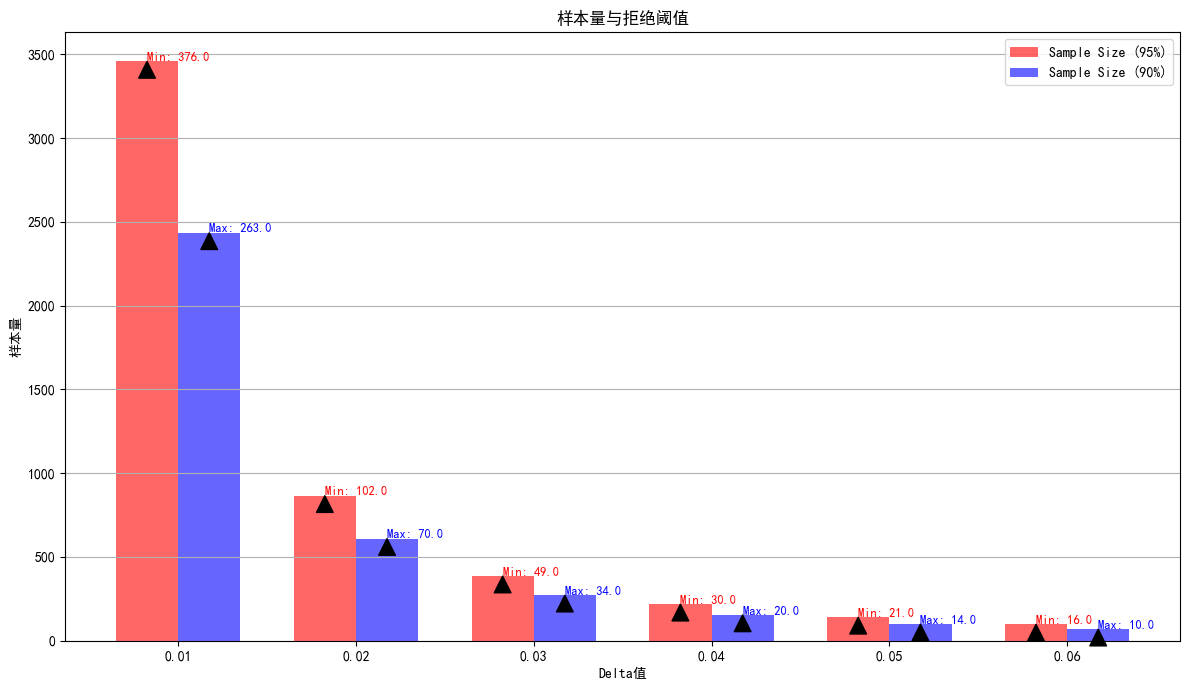

In [7]:
# 可视化拒绝域
plt.figure(figsize=(12, 7))

# 绘制直方图
bar_width = 0.35
index = np.arange(len(df))

# 绘制样本量
plt.bar(index, df['Sample Size (95%)'], bar_width, label='Sample Size (95%)', color='red', alpha=0.6)
plt.bar(index + bar_width, df['Sample Size (90%)'], bar_width, label='Sample Size (90%)', color='blue', alpha=0.6)

# 添加拒绝域的标注
for i, row in df.iterrows():
    plt.annotate(f'Min: {row["Min Defects (95%)"]}', xy=(i, row['Sample Size (95%)']), 
                 xytext=(i, row['Sample Size (95%)'] + 2), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9, color='red')
    plt.annotate(f'Max: {row["Max Defects (90%)"]}', xy=(i + bar_width, row['Sample Size (90%)']), 
                 xytext=(i + bar_width, row['Sample Size (90%)'] + 2), 
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=9, color='blue')

# 设置图例
plt.legend(loc='best')

# 添加标题和标签
plt.title('样本量与拒绝阈值')
plt.xlabel('Delta值')
plt.ylabel('样本量')

# 设置 x 轴刻度
plt.xticks(index + bar_width / 2, df['Delta'])

# 添加网格
plt.grid(axis='y')

# 显示图形
plt.tight_layout()
plt.show()

### 计算决策正确率


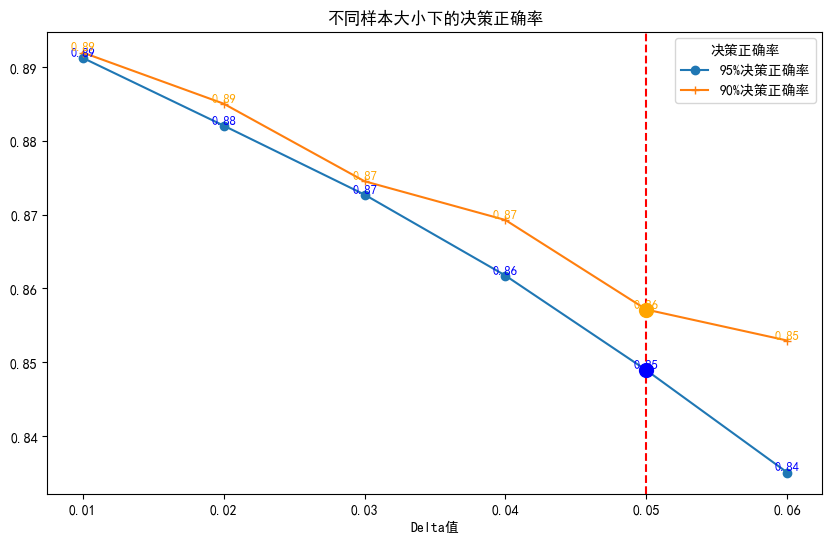

In [8]:
df['Decision Accuracy (95%)'] = (df['Sample Size (95%)']- df['Min Defects (95%)']) / df['Sample Size (95%)']
df['Decision Accuracy (90%)'] = (df['Sample Size (90%)'] - df['Max Defects (90%)']) / df['Sample Size (90%)']
# 绘制折线图
plt.figure(figsize=(10, 6))# 图长宽
plt.plot(df['Delta'], df['Decision Accuracy (95%)'], marker='o', label='95%决策正确率')# x轴、y轴、点的形状、图例名字
plt.plot(df['Delta'], df['Decision Accuracy (90%)'], marker='+', label='90%决策正确率')
plt.title('不同样本大小下的决策正确率')
plt.xlabel('Delta值')
plt.legend(title='决策正确率', loc='best')  # 添加图例并设置标题
# 在每个点上显示函数值
for i in range(len(df)):
    plt.text(df['Delta'][i], df['Decision Accuracy (95%)'][i], f"{df['Decision Accuracy (95%)'][i]:.2f}", 
             fontsize=9, ha='center', va='bottom', color='blue')
    plt.text(df['Delta'][i], df['Decision Accuracy (90%)'][i], f"{df['Decision Accuracy (90%)'][i]:.2f}", 
             fontsize=9, ha='center', va='bottom', color='orange')
# 添加竖线和标记点
delta_mark = 0.05
plt.axvline(x=delta_mark, color='red', linestyle='--', label='Delta = 0.05')
plt.scatter(delta_mark, df.loc[df['Delta'] == delta_mark, 'Decision Accuracy (95%)'].values[0], color='blue', s=100, zorder=5)  
plt.scatter(delta_mark, df.loc[df['Delta'] == delta_mark, 'Decision Accuracy (90%)'].values[0], color='orange', s=100, zorder=5)  

### 分析图像确定E从而选择样本量

1. 样本量越多，正确率提升不高(接近或小于0.01的提升），但是成本高得多(相邻2个增加4倍到2倍不等），固选合适的**0.05**作为E值
<table>
    <tr>
        <th>Index</th>
        <th>Delta</th>
        <th>Sample Size (95%)</th>
        <th>Min Defects (95%)</th>
        <th>Sample Size (90%)</th>
        <th>Max Defects (90%)</th>
    </tr>
    <tr>
        <td>1</td>
        <td>0.01</td>
        <td>3458.0</td>
        <td>375.0</td>
        <td>2435.0</td>
        <td>224.0</td>
    </tr>
    <tr>
        <td>2</td>
        <td>0.02</td>
        <td>865.0</td>
        <td>102.0</td>
        <td>609.0</td>
        <td>51.0</td>
    </tr>
    <tr>
        <td>3</td>
        <td>0.03</td>
        <td>385.0</td>
        <td>49.0</td>
        <td>271.0</td>
        <td>20.0</td>
    </tr>
    <tr>
        <td>4</td>
        <td>0.04</td>
        <td>217.0</td>
        <td>29.0</td>
        <td>153.0</td>
        <td>10.0</td>
    </tr>
    <tr style="color: powderblue;">
        <td>5</td>
        <td>0.01</td>
        <td>139.0</td>
        <td1420.0</td>
        <td>98.0</td>
        <td>5.0</td>
    </tr>
    <tr>
        <td>6</td>
        <td>0.06</td>
        <td>97.0</td>
        <td>15.0</td>
        <td>68.0</td>
        <td>3.0</td>
    </tr>
</table>
      |

3. 取的E计算的样本都为**大样本**，之后使用**正态分布**近似二项分布，可以使用Z统计量作为检验统计量  


### 可视化delta为0.05时的拒绝域
方便理解😆

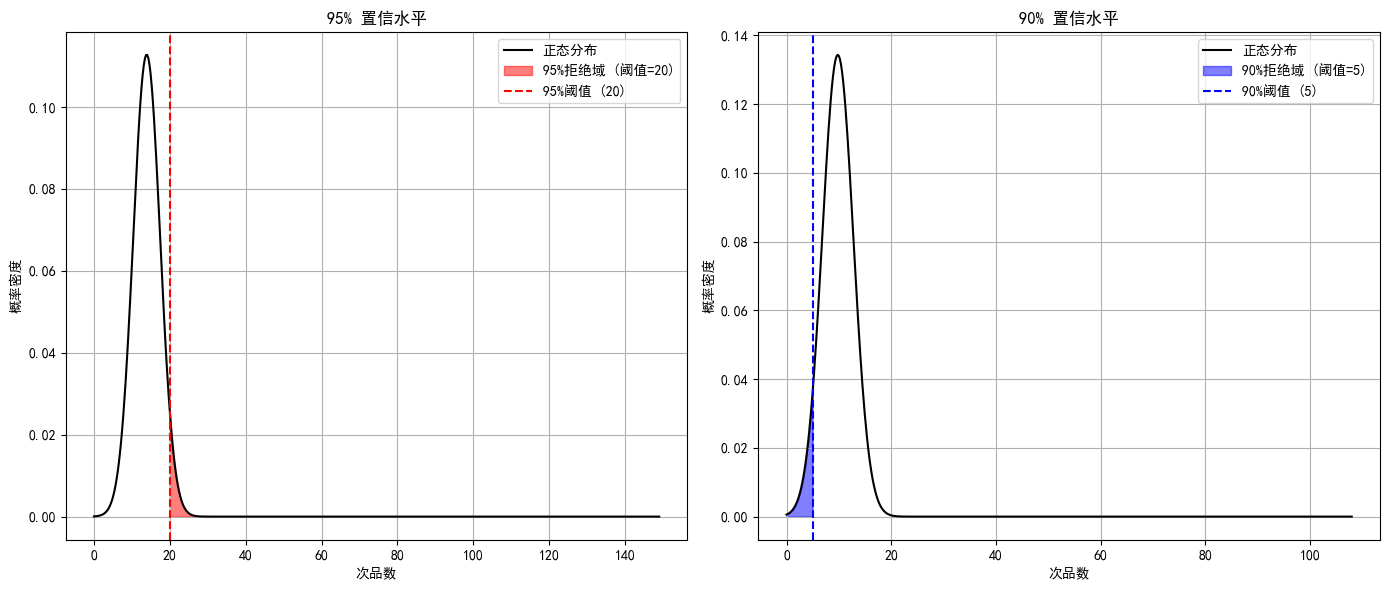

In [9]:
# 设置基础参数
# 0.05时的样本量
n_95 = 139
n_90 = 98

# 0.05对应的阈值
d_95 = 20
d_90 = 5

# 创建子图1行俩
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# 定义x轴范围
x_95 = np.linspace(0, n_95 + 10, 500)  # 95%图的x轴范围
x_90 = np.linspace(0, n_90 + 10, 500)  # 90%图的x轴范围

# 计算95%置信水平对应的正态分布
pdf_95 = norm.pdf(x_95, loc=n_95 * p0, scale=np.sqrt(n_95 * p0 * (1 - p0)))

# 绘制95%右侧检验的正态分布曲线和拒绝域
axs[0].plot(x_95, pdf_95, label="正态分布", color='black')
axs[0].fill_between(x_95, pdf_95, where=(x_95 >= d_95), color='red', alpha=0.5, label=f"95%拒绝域 (阈值={d_95})")
axs[0].axvline(x=d_95, color='red', linestyle='--', label=f"95%阈值 ({d_95})")
axs[0].set_title("95% 置信水平")
axs[0].set_xlabel('次品数')
axs[0].set_ylabel('概率密度')
axs[0].legend()
axs[0].grid(True)

# 计算90%置信水平对应的正态分布
pdf_90 = norm.pdf(x_90, loc=n_90 * p0, scale=np.sqrt(n_90 * p0 * (1 - p0)))

# 绘制90%左侧检验的正态分布曲线和拒绝域
axs[1].plot(x_90, pdf_90, label="正态分布", color='black')
axs[1].fill_between(x_90, pdf_90, where=(x_90 <= d_90), color='blue', alpha=0.5, label=f"90%拒绝域 (阈值={d_90})")
axs[1].axvline(x=d_90, color='blue', linestyle='--', label=f"90%阈值 ({d_90})")
axs[1].set_title("90% 置信水平")
axs[1].set_xlabel('次品数')
axs[1].set_ylabel('概率密度')
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()


## 得出结论
**方案一**： 
在95%的置信水平：在139个样本中检测到超过21个次品，拒收；  
在90%的置信水平：在98个样本中检测到不超过14个次品，接收。  

**方案二**：  
观察次品数k,计算Z检验统计量$Z = \frac{p - \pi_0}{\sqrt{\frac{\pi_0(1 - \pi_0)}{n}}}$
  
计算次品率k/n_95，若$Z>Z_{\alpha /2}$ ($\alpha =0.05$,$Z_{\alpha} \approx 1.96$)，拒收；  
计算次品率k/n_90，若$Z>Z_{\alpha /2}$ ($\alpha =0.1$,$Z_{\alpha} \approx 1.645$)，接收。

# 2️⃣Problem2
**目标**：分析不同情况下的决策方案：  
1. 最小化成本（检测+处理不合格成品+调换损失）
2. 最大化利润  
**方法**：
<font color=Navy size=5>模拟退火算法计算目标函数最优解，使用遗传算法进行结果检验</font>

## 定义目标函数 end

In [10]:
# 定义利润函数
def profit_function(detect_p1, detect_p2, detect_final, recycle, p1, p2, pf, cd, cr, cs, cl, r, n):
    cost_detection = ((p1 if detect_p1 else 0) + (p2 if detect_p2 else 0) + (pf if detect_final else 0)) * n * cd
    cost_loss = pf * n * cl
    cost_recycling = (pf * n - r) * cr if recycle else pf * n * cr
    return n * cs - (cost_detection + cost_loss + cost_recycling)

## 设置参数并模拟退火
从左到右分别为:
零配件1的次品率  
零配件2的次品率  
成品次品率  
零件1检测成本❓️  
拆解成品成本
销售价格    
调换损失成本  
回收零配件再利用的价值❓️  
销售数量（此值通常较大，此处设置为1以便计算）  
plus：零件组装成本见3️⃣

In [11]:
# 定义情况的参数
situations = [
    (0.10, 0.10, 0.10, 2, 5, 56, 6, 0.5, 1),
    (0.20, 0.20, 0.20, 2, 5, 56, 6, 0.5, 1),
    (0.10, 0.10, 0.10, 2, 5, 56, 30, 0.5, 1),   
    (0.20, 0.20, 0.20, 1, 5, 56, 30, 0.5, 1),
    (0.10, 0.20, 0.10, 8, 5, 56, 10, 0.5, 1),
    (0.05, 0.05, 0.05, 2, 40, 56, 10, 0.5, 1),
]
results = []

In [12]:
# 对每种情况进行模拟退火  
for case_id, params in enumerate(situations, start=1):  
    p1, p2, pf, cd, cr, cs, cl, r, n = params  
    
    # 初始状态  
    initial_state = [True, True, True, True]  # 检测零配件1, 检测零配件2, 检测成品, 回收不合格成品  
    initial_profit = profit_function(*initial_state, p1, p2, pf, cd, cr, cs, cl, r, n)  

    # 模拟退火算法参数  
    T = 1000  # 初始温度  
    T_min = 0.01  # 最小温度  
    alpha = 0.99  # 温度衰减系数  
    steps = 1000  # 每个温度下的步数  

    # 模拟退火算法  
    current_state = initial_state[:]  # 初始化状态  
    current_profit = initial_profit  # 初始化利润值  
    best_state = current_state[:]  
    best_profit = current_profit  

    while T > T_min:  
        for i in range(steps):  
            # 产生新状态  
            new_state = current_state[:]  
            for j in range(len(new_state)):  
                if random.random() < 0.5:  
                    new_state[j] = not new_state[j]  
            new_profit = profit_function(*new_state, p1, p2, pf, cd, cr, cs, cl, r, n)  

            # 接受新状态的概率  
            if new_profit > current_profit or random.random() < math.exp((new_profit - current_profit) / T):  
                current_state = new_state  
                current_profit = new_profit  
                if current_profit > best_profit:  
                    best_state = current_state  
                    best_profit = current_profit  
        T *= alpha  # 降温  

    # 存储结果   
    results.append({  
        "情况": case_id,  
        "最大利润": best_profit,  
        "是否检测零配件": "是" if best_state[0] else "否",  
        "是否检测成品": "是" if best_state[1] else "否",  
        "是否拆解不合格产品": "是" if best_state[2] else "否",  
        "是否调换退回产品": "是" if best_state[3] else "否"  
    })  

# 创建 DataFrame  
results_df = pd.DataFrame(results)  
print(results_df)   

# 保存结果到 CSV 文件  
try:  
    results_df.to_csv('results2.csv', index=False)  
    print("-----------------！数据成功保存到 results2.csv------------------------")  
except Exception as e:  
    print("数据保存失败:", e)  

   情况  最大利润 是否检测零配件 是否检测成品 是否拆解不合格产品 是否调换退回产品
0   1  57.4       否      否         否        是
1   2  56.3       否      否         否        是
2   3  55.0       否      否         否        是
3   4  51.5       否      否         否        是
4   5  57.0       否      否         否        是
5   6  73.5       否      否         否        是
-----------------！数据成功保存到 results2.csv------------------------


## 遗传算法检验结果

In [13]:
# 适应度函数
def fitness(individual, params):
    return profit_function(*individual, *params)

In [14]:
# 初始化种群
def init_population(size):
    return [[random.choice([True, False]) for _ in range(4)] for _ in range(size)] # [随机[T,T,F,F],共size行]

In [15]:
# 选择函数
def selection(population, fitnesses, k=3):#list,list,从种群中随机选k个个体进行比较
    selected = random.sample(list(zip(population, fitnesses)), k)#population, fitnesses配对形成元组->变为列表->随机选k个元组
    return max(selected, key=lambda x: x[1])[0]# 从k个体中找到适应度最大的个体，x[1]比较的是适应度,取第一个x[0]

In [16]:
# 交叉操作
def crossover(parent1, parent2):
    child1 = parent1[:]
    child2 = parent2[:]
    for i in range(len(parent1)):
        if random.random() < 0.5:# 随机更新
            child1[i], child2[i] = parent2[i], parent1[i]
    return child1, child2

In [17]:
# 变异操作
def mutate(individual, mutation_rate=0.05):
    for i in range(len(individual)):
        if random.random() < mutation_rate:# 随机变异
            individual[i] = not individual[i]
    return individual

In [18]:
# 遗传算法主循环
def genetic_algorithm(pop_size=50, generations=100, params=None):
    population = init_population(pop_size)
    best_solution = None
    best_fitness = float('-inf')

    for _ in range(generations):
        # 计算适应度
        fitnesses = [fitness(ind, params) for ind in population]

        # 更新最佳个体
        for ind, fit in zip(population, fitnesses):
            if fit > best_fitness:
                best_solution = ind
                best_fitness = fit

        # 新一代种群
        new_population = []
        while len(new_population) < pop_size:
            # 选择父母
            parent1 = selection(population, fitnesses)
            parent2 = selection(population, fitnesses)

            # 交叉
            offspring1, offspring2 = crossover(parent1, parent2)

            # 变异
            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)

            new_population.extend([offspring1, offspring2])

        population = new_population

    return best_solution, best_fitness

# 运行遗传算法并收集结果
results = []
for case_id, params in enumerate(situations):
    p1, p2, pf, cd, cr, cs, cl, r, n = params
    
    # 使用遗传算法
    best_solution, best_profit = genetic_algorithm(params=params)

    # 解析最佳状态
    best_state = best_solution  # 假设 best_solution 是一个可迭代对象，包含检测状态
    results.append({  
        "情况": case_id + 1,  # 从 1 开始编号
        "最大利润": best_profit,  
        "是否检测零配件1": "是" if best_state[0] else "否",  
        "是否检测零配件2": "是" if best_state[1] else "否",  
        "是否检测成品": "是" if best_state[2] else "否",  
        "是否拆解不合格产品": "是" if best_state[3] else "否"  
    })  

# 创建 DataFrame  
results_df = pd.DataFrame(results)  
print(results_df)   

# 保存结果到 CSV 文件  
try:  
    results_df.to_csv('results2_ga.csv', index=False)  
    print("-----------------！数据成功保存到 results2_ga.csv------------------------")  
except Exception as e:  
    print("数据保存失败:", e)


   情况  最大利润 是否检测零配件1 是否检测零配件2 是否检测成品 是否拆解不合格产品
0   1  57.4        否        否      否         是
1   2  56.3        否        否      否         是
2   3  55.0        否        否      否         是
3   4  51.5        否        否      否         是
4   5  57.0        否        否      否         是
5   6  73.5        否        否      否         是
-----------------！数据成功保存到 results2_ga.csv------------------------


# 3️⃣Problem3
增加半成品装配成本、半成品检测成本、成品装配成本、成品检测成本、拆解费用更新目标函数

## 模拟退火

In [19]:
# 定义参数
p1 = p2 = p3 = p4 = p5 = p6 = p7 = p8 = 0.10  # 各零配件的次品率
pf = 0.10  # 成品的次品率
cd = [1, 1, 2, 1, 1, 2, 1, 2]  # 各零配件的检测成本
c_parts = [2, 8, 12, 2, 8, 12, 8, 12]  # 各零配件的购买单价
cs = 200  # 销售价格
cl = 40  # 损失成本
cr = 10  # 回收成本
n = 1  # 销售数量（此值通常较大，此处设置为1以便计算）
assembly_costs = [8, 8, 8]  # 半成品装配成本
assembly_tests = [4, 4, 4]  # 半成品检测成本
final_assembly = 8  # 成品装配成本
final_test = 6  # 成品检测成本
disassembly_cost = 10  # 拆解费用

In [20]:
# 利润函数
def profit_function(detect_parts, detect_final, recycle):
    # 计算零配件的检测成本
    cost_detection_parts = sum(cd[i] * n * detect_parts[i] for i in range(len(cd)))
    # 计算半成品和成品的检测成本
    cost_detection_final = (sum(assembly_tests) + final_test) * n * detect_final
    # 计算总成本
    total_cost = sum(c_parts) + sum(assembly_costs) + final_assembly + cost_detection_parts + cost_detection_final
    # 计算损失成本
    cost_loss = pf * n * cl
    # 计算回收成本
    cost_recycling = (pf * n - 0.5) * cr if recycle else pf * n * cr
    # 返回利润
    return n * cs - (total_cost + cost_loss + cost_recycling)

In [21]:
# 初始状态
initial_state = [True] * 8 + [True, True]  # 是否检测零配件1至8, 是否检测成品, 是否回收不合格成品
initial_profit = profit_function(initial_state[:-2], initial_state[-2], initial_state[-1])

# 模拟退火算法参数
T = 1000  # 初始温度
T_min = 0.01  # 最小温度
alpha = 0.99  # 温度衰减系数
steps = 1000  # 每个温度下的步数

In [22]:
# 模拟退火算法
current_state = initial_state[:]
current_profit = initial_profit
best_state = current_state[:]
best_profit = current_profit

while T > T_min:
    for i in range(steps):
        # 产生新状态
        new_state = current_state[:]
        for j in range(len(new_state)):
            if random.random() < 0.5:
                new_state[j] = not new_state[j]
        new_profit = profit_function(new_state[:-2], new_state[-2], new_state[-1])

        # 接受新状态的概率
        if new_profit > current_profit or random.random() < math.exp((new_profit - current_profit) / T):
            current_state = new_state
            current_profit = new_profit
            if current_profit > best_profit:
                best_state = current_state
                best_profit = current_profit
    T *= alpha

results = pd.DataFrame(columns=["最大利润", "零配件1", "零配件2", "零配件3", "零配件4", "零配件5", "零配件6", "零配件7", "零配件8", "成品", "不合格成品"])

results = pd.concat([results, pd.DataFrame({
    "最大利润": [best_profit],
    "零配件1": "不检测" if best_state[0] else "检测",
    "零配件2": "不检测" if best_state[1] else "检测",
    "零配件3": "不检测" if best_state[2] else "检测",
    "零配件4": "不检测" if best_state[3] else "检测",
    "零配件5": "不检测" if best_state[4] else "检测",
    "零配件6": "不检测" if best_state[5] else "检测",
    "零配件7": "不检测" if best_state[6] else "检测",
    "零配件8": "不检测" if best_state[7] else "检测",
    "成品": "不检测" if best_state[8] else "检测",
    "不合格成品": "回收" if best_state[9] else "不回收"
})], ignore_index=True)

print(results)

# 保存结果到 CSV 文件
try:
    results.to_csv('results3.csv', index=False)
    print("数据成功保存到 results3.csv")
except Exception as e:
    print("数据保存失败:", e)

    最大利润 零配件1 零配件2 零配件3 零配件4 零配件5 零配件6 零配件7 零配件8  成品 不合格成品
0  104.0   检测   检测   检测   检测   检测   检测   检测   检测  检测    回收
数据成功保存到 results3.csv


C:\Users\colin\AppData\Local\Temp\ipykernel_17544\3293209191.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


## 检验1：遗传算法

In [23]:
# 初始化种群
def initialize_population(population_size):
    return [
        [random.choice([True, False]) for _ in range(8)] + [random.choice([True, False]), random.choice([True, False])]
        for _ in range(population_size)]

In [24]:
# 适应度评估
def fitness(individual):
    detect_parts = individual[:-2]
    detect_final = individual[-2]
    recycle = individual[-1]
    return profit_function(detect_parts, detect_final, recycle)

In [25]:
# 选择
def selection(population, fitness_values, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = max(zip(fitness_values, population), key=lambda x: x[0])
        parents.append(selected[1])
        fitness_values.remove(selected[0])
        population.remove(selected[1])
    return parents

In [26]:
# 交叉
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

In [27]:
# 变异
def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = not individual[i]
    return individual

In [28]:
# 主循环
def genetic_algorithm(population_size=100, num_generations=100, mutation_rate=0.05):
    population = initialize_population(population_size)

    for generation in range(num_generations):
        fitness_values = [fitness(individual) for individual in population]

        # 选择最佳个体
        best_individual = max(zip(fitness_values, population), key=lambda x: x[0])[1]
        best_fitness = fitness(best_individual)

        # 选择父母
        num_parents = int(population_size / 2)
        parents = selection(population, fitness_values, num_parents)

        # 生成后代
        offspring = []
        while len(offspring) < population_size:
            if len(parents) < 2:
                parents = selection(population, fitness_values, num_parents)
            parent1, parent2 = random.sample(parents, 2)
            child1, child2 = crossover(parent1, parent2)
            offspring.extend([mutate(child1, mutation_rate), mutate(child2, mutation_rate)])

        # 替换旧种群
        population = offspring

    return best_individual, best_fitness

In [29]:
# 执行遗传算法
optimal_Q, optimal_profit = genetic_algorithm()
print(f"Optimal Quantity: {optimal_Q}, Optimal Profit: {optimal_profit}")

Optimal Quantity: [False, False, False, False, False, False, False, False, False, True], Optimal Profit: 104.0


## 检验2：粒子群算法

In [30]:
# 初始化粒子群
def initialize_particles(num_particles):
    particles = []
    velocities = []
    personal_best_positions = []
    personal_best_fitnesses = []

    for _ in range(num_particles):
        particle = np.random.choice([0, 1], size=10)# 随机生成10个粒子（决策变量）的位置（0或1）
        velocity = np.zeros(10)# 初始化速度为0
        particles.append(particle)
        velocities.append(velocity)
        personal_best_positions.append(particle.copy()) # 记录个人最佳位置
        personal_best_fitnesses.append(profit_function(particle[:-2], particle[-2], particle[-1]))

    global_best_position = particles[np.argmax(personal_best_fitnesses)]# 返回第一个最大值的索引即全局最优解位置
    global_best_fitness = max(personal_best_fitnesses)# 计算全局最优解适应度，用于后续更新

    return particles, velocities, personal_best_positions, personal_best_fitnesses, global_best_position, global_best_fitness

In [31]:
# 更新粒子的速度和位置
def update_particles(particles, velocities, personal_best_positions, global_best_position, w=0.7, c1=2.0, c2=2.0):
    new_particles = []
    new_velocities = []
    new_personal_best_positions = personal_best_positions.copy()# 不影响传参值得拷贝
    new_personal_best_fitnesses = []
    global_best_fitness = profit_function(global_best_position[:-2], global_best_position[-2], global_best_position[-1])

    for i, (particle, velocity, personal_best) in enumerate(zip(particles, velocities, personal_best_positions)):# 创建元组得同时给它加一列索引列
        r1, r2 = np.random.rand(), np.random.rand()# 随机权重
        cognitive_component = c1 * r1 * (personal_best - particle)# 个人最佳影响
        social_component = c2 * r2 * (global_best_position - particle)# 全局最优影响
        velocity = w * velocity + cognitive_component + social_component# 根据上面俩更新速度
        particle = np.clip(particle + velocity, 0, 1).astype(int)# 从而更新位置clip限制范围在0~1.小于0为0，大一1为1—>转化为整数类型
        fitness = profit_function(particle[:-2], particle[-2], particle[-1])
        new_particles.append(particle)
        new_velocities.append(velocity)
        
        #更新个人最佳位置
        if fitness > profit_function(personal_best[:-2], personal_best[-2], personal_best[-1]):
            new_personal_best_positions[i] = particle
            new_personal_best_fitnesses.append(fitness)
        else:
            new_personal_best_fitnesses.append(
                profit_function(personal_best[:-2], personal_best[-2], personal_best[-1]))
        # 更新全局最佳位置
        if fitness > global_best_fitness:
            global_best_position = particle
            global_best_fitness = fitness

    return new_particles, new_velocities, new_personal_best_positions, new_personal_best_fitnesses, global_best_position, global_best_fitness

In [32]:
# 主循环
def pso_algorithm(num_particles=50, num_iterations=100):
    particles, velocities, personal_best_positions, personal_best_fitnesses, global_best_position, global_best_fitness = initialize_particles(
        num_particles)

    for iteration in range(num_iterations):
        particles, velocities, personal_best_positions, personal_best_fitnesses, global_best_position, global_best_fitness = update_particles(
            particles, velocities, personal_best_positions, global_best_position)

    return global_best_position, global_best_fitness

In [33]:
# 执行粒子群优化算法
optimal_Q, optimal_profit = pso_algorithm()
print(f"Optimal Quantity: {optimal_Q}, Optimal Profit: {optimal_profit}")

Optimal Quantity: [0 0 0 0 0 0 0 0 0 1], Optimal Profit: 104.0


# 4️⃣Problem4
零配件、半成品和成品的次品率需要抽样检测
**方法**：  
加入<font color=Navy size=5>蒙特卡洛模拟</font>对抽样进行评估，确定置信区间范围  
使用均匀分布随机模拟次品率

## 重做2️⃣

### 蒙特卡洛

In [34]:
# 参数
p = 0.11  # 次品率
n = 139   # 样本量

# 计算抽样误差（标准误差）
se = np.sqrt(p * (1 - p) / n)

# 95%置信水平下的z分数
z = norm.ppf(0.975)  # 由于我们要覆盖两侧，所以我们取0.95的上侧点，即0.975

In [35]:
# 计算置信区间的下限和上限
lower_bound = p - z * se
upper_bound = p + z * se

print(f"抽样误差（标准误差）: {se:.4f}")
print(f"次品率的95%置信区间: ({lower_bound:.4f}, {upper_bound:.4f})")

抽样误差（标准误差）: 0.0265
次品率的95%置信区间: (0.0580, 0.1620)


### 均匀分布模拟次品率

In [36]:
#随机抽取18个次品率
# 置信区间
lower_bound = 0.0580
upper_bound = 0.1620

# 随机数的数量
num_samples = 18

# 创建一个等间距的序列
base_values = np.linspace(lower_bound, upper_bound, num_samples)

# 添加一些小的随机扰动，使数值更自然
random_noise = np.random.uniform(-0.005, 0.005, size=num_samples)
sampled_values = base_values + random_noise

# 确保所有数值都在置信区间内
sampled_values = np.clip(sampled_values, lower_bound, upper_bound)

# 四舍五入到百分位
rounded_values = np.round(sampled_values, 2)

# 打印结果
print(rounded_values)

[0.06 0.07 0.07 0.08 0.08 0.09 0.1  0.11 0.1  0.11 0.12 0.13 0.14 0.14
 0.15 0.15 0.15 0.16]


### 将得到的18个随机数插入进问题2的表格里

In [37]:
# 给定的随机数
random_rates = [0.06, 0.06, 0.07, 0.07, 0.08, 0.09, 0.09, 0.1, 0.1, 0.11, 0.12, 0.13, 0.13, 0.14, 0.14, 0.15, 0.15, 0.16]

# 给定的数据表
data = [
    [1, 0.05, 4, 2, 0.07, 18, 3, 0.06, 6, 3, 56, 6, 5],
    [2, 0.02, 4, 2, 0.08, 18, 3, 0.07, 6, 3, 56, 6, 5],
    [3, 0.05, 4, 2, 0.05, 18, 3, 0.05, 6, 3, 56, 30, 5],
    [4, 0.03, 4, 1, 0.02, 18, 1, 0.06, 6, 2, 56, 30, 5],
    [5, 0.05, 4, 8, 0.08, 18, 1, 0.04, 6, 2, 56, 10, 5],
    [6, 0.03, 4, 2, 0.07, 18, 3, 0.04, 6, 3, 56, 10, 40]
]

In [38]:
# 将次品率的位置存储在一个列表中
def get_defect_rate_positions(data):
    positions = []
    for row_index, row in enumerate(data):
        for col_index, value in enumerate(row):
            if isinstance(value, float) and 0 < value <= 1:# 因为次品率是个float
                positions.append((row_index, col_index))
    return positions

In [39]:
# 获取次品率的位置
positions = get_defect_rate_positions(data)

# 随机打乱随机数的顺序
np.random.shuffle(random_rates)

# 将随机数插入到次品率的位置
for i, pos in enumerate(positions):
    data[pos[0]][pos[1]] = random_rates[i]

# 打印修改后的数据
for row in data:
    print(row)

[1, 0.14, 4, 2, 0.06, 18, 3, 0.15, 6, 3, 56, 6, 5]
[2, 0.16, 4, 2, 0.07, 18, 3, 0.08, 6, 3, 56, 6, 5]
[3, 0.07, 4, 2, 0.06, 18, 3, 0.15, 6, 3, 56, 30, 5]
[4, 0.13, 4, 1, 0.13, 18, 1, 0.09, 6, 2, 56, 30, 5]
[5, 0.1, 4, 8, 0.12, 18, 1, 0.09, 6, 2, 56, 10, 5]
[6, 0.1, 4, 2, 0.14, 18, 3, 0.11, 6, 3, 56, 10, 40]


### 模拟退火

In [40]:
results = []  
 
for row in data:  
    case_id = row[0]  
    p1 = row[1]  # 零配件1的次品率  
    p2 = row[4]  # 零配件2的次品率  
    pf = row[7]  # 成品的次品率  
    cd = row[2]  # 检测成本  
    cr = row[5]  # 回收成本  
    cs = row[10]  # 销售价格  
    cl = row[9]  # 损失成本  
    r = 0.5  # 回收零配件再利用的价值  
    n = 1  # 销售数量（此值通常较大，此处设置为1以便计算）  

    # 利润函数 
    def profit_function(detect_p1, detect_p2, detect_final, recycle):  
        cost_detection = ((detect_p1 * p1) + (detect_p2 * p2) + (detect_final * pf)) * cd  
        cost_loss = pf * cl  
        cost_recycling = (pf * n - r) * cr if recycle else pf * cr  
        return cs - (cost_detection + cost_loss + cost_recycling)  

    # 初始状态
    initial_state = [True, True, True, True]  # 是否检测零配件1, 是否检测零配件2, 是否检测成品, 是否回收不合格成品  
    initial_profit = profit_function(*initial_state)  

    # 模拟退火算法参数 
    T = 1000  # 初始温度  
    T_min = 0.01  # 最小温度  
    alpha = 0.99  # 温度衰减系数  
    steps = 1000  # 每个温度下的步数  

    # 模拟退火算法 
    current_state = initial_state[:]  
    current_profit = initial_profit  
    best_state = current_state[:]  
    best_profit = current_profit  

    while T > T_min:  
        for i in range(steps):  
            # 产生新状态  
            new_state = current_state[:]  
            for j in range(len(new_state)):  
                if random.random() < 0.5:  
                    new_state[j] = not new_state[j]  
            new_profit = profit_function(*new_state)  

            # 接受新状态的概率  
            if new_profit > current_profit or random.random() < math.exp((new_profit - current_profit) / T):  
                current_state = new_state  
                current_profit = new_profit  
                if current_profit > best_profit:  
                    best_state = current_state  
                    best_profit = current_profit  
        T *= alpha  

    # 存储结果 
    results.append({  
        "情况": case_id,  
        "最大利润": best_profit,  
        "是否检测零配件": "是" if best_state[0] else "否",  
        "是否检测成品": "是" if best_state[1] else "否",  
        "是否拆解不合格产品": "是" if best_state[2] else "否",  
        "是否调换退回产品": "是" if best_state[3] else "否"  
    })  
 
results = pd.DataFrame(results)  
print(results) 
try:
    results.to_csv('results4_2.csv', index=False)
    print("数据成功保存到 results4_2.csv")
except Exception as e:
    print("数据保存失败:", e)

   情况   最大利润 是否检测零配件 是否检测成品 是否拆解不合格产品 是否调换退回产品
0   1  61.85       否      否         否        是
1   2  63.32       否      否         否        是
2   3  61.85       否      否         否        是
3   4  63.20       否      否         否        是
4   5  63.20       否      否         否        是
5   6  62.69       否      否         否        是
数据成功保存到 results4_2.csv


## 重做3️⃣

### 蒙特卡洛

In [41]:
# 给定参数
p = 0.10  # 次品率
n = 139   # 样本量

# 计算抽样误差（标准误差）
se = np.sqrt(p * (1 - p) / n)

# 95%置信水平下的z分数
z = norm.ppf(0.975)  # 由于我们要覆盖两侧，所以我们取0.95的上侧点，即0.975

# 计算置信区间的下限和上限
lower_bound = p - z * se
upper_bound = p + z * se

print(f"抽样误差（标准误差）: {se:.4f}")
print(f"次品率的95%置信区间: ({lower_bound:.4f}, {upper_bound:.4f})")


抽样误差（标准误差）: 0.0254
次品率的95%置信区间: (0.0501, 0.1499)


### 均匀分布取5个随机数

In [42]:
# 置信区间
lower_bound = 0.0501
upper_bound = 0.1499

# 随机数的数量
num_samples = 5

# 使用均匀分布生成随机数
random_numbers = np.random.uniform(lower_bound, upper_bound, size=num_samples)

# 四舍五入到百分位
rounded_numbers = np.round(random_numbers, 2)

print(rounded_numbers)

[0.07 0.11 0.08 0.09 0.14]


### 模拟退火

In [43]:
# 参数
p_values = [0.05, 0.07, 0.11, 0.12, 0.13]  # 各种次品率
cd = [1, 1, 2, 1, 1, 2, 1, 2]  # 各零配件的检测成本
c_parts = [2, 8, 12, 2, 8, 12, 8, 12]  # 各零配件的购买单价
cs = 200  # 销售价格
cl = 40  # 损失成本
cr = 10  # 回收成本
n = 1  # 销售数量（此值通常较大，此处设置为1以便计算）
assembly_costs = [8, 8, 8]  # 半成品装配成本
assembly_tests = [4, 4, 4]  # 半成品检测成本
final_assembly = 8  # 成品装配成本
final_test = 6  # 成品检测成本
disassembly_cost = 10  # 拆解费用

# 利润函数
def profit_function(detect_parts, detect_final, recycle, p):
    # 计算零配件的检测成本
    cost_detection_parts = sum(cd[i] * n * detect_parts[i] for i in range(len(cd)))
    # 计算半成品和成品的检测成本
    cost_detection_final = (sum(assembly_tests) + final_test) * n * detect_final
    # 计算总成本
    total_cost = sum(c_parts) + sum(assembly_costs) + final_assembly + cost_detection_parts + cost_detection_final
    # 计算损失成本
    cost_loss = p * n * cl
    # 计算回收成本
    cost_recycling = (p * n - 0.5) * cr if recycle else p * n * cr
    # 返回利润
    return n * cs - (total_cost + cost_loss + cost_recycling)

# 初始化 DataFrame
results = pd.DataFrame(columns=["次品率", "最大利润", "零配件1", "零配件2", "零配件3", "零配件4", "零配件5", "零配件6", "零配件7", "零配件8", "成品", "不合格成品"])

# 模拟退火算法参数
T = 1000  # 初始温度
T_min = 0.01  # 最小温度
alpha = 0.99  # 温度衰减系数
steps = 1000  # 每个温度下的步数

# 对每个次品率进行计算
for p_actual in p_values:
    # 初始状态
    initial_state = [True] * 8 + [True, True]  # 是否检测零配件1至8, 是否检测成品, 是否回收不合格成品
    initial_profit = profit_function(initial_state[:-2], initial_state[-2], initial_state[-1], p_actual)

    # 模拟退火算法
    current_state = initial_state[:]
    current_profit = initial_profit
    best_state = current_state[:]
    best_profit = current_profit

    while T > T_min:
        for i in range(steps):
            # 产生新状态
            new_state = current_state[:]
            for j in range(len(new_state)):
                if random.random() < 0.5:
                    new_state[j] = not new_state[j]
            new_profit = profit_function(new_state[:-2], new_state[-2], new_state[-1], p_actual)

            # 接受新状态的概率
            if new_profit > current_profit or random.random() < math.exp((new_profit - current_profit) / T):
                current_state = new_state
                current_profit = new_profit
                if current_profit > best_profit:
                    best_state = current_state
                    best_profit = current_profit
        T *= alpha

    # 将结果添加到 DataFrame
    results = pd.concat([results, pd.DataFrame({
        "次品率": [p_actual],
        "最大利润": [best_profit],
        "零配件1": "检测" if best_state[0] else "不检测",
        "零配件2": "检测" if best_state[1] else "不检测",
        "零配件3": "检测" if best_state[2] else "不检测",
        "零配件4": "检测" if best_state[3] else "不检测",
        "零配件5": "检测" if best_state[4] else "不检测",
        "零配件6": "检测" if best_state[5] else "不检测",
        "零配件7": "检测" if best_state[6] else "不检测",
        "零配件8": "检测" if best_state[7] else "不检测",
        "成品": "检测" if best_state[8] else "不检测",
        "不合格成品": "回收" if best_state[9] else "不回收"
    })], ignore_index=True)

print(results)
try:
    results.to_csv('results4_3.csv', index=False)
    print("数据成功保存到 results4_3.csv")
except Exception as e:
    print("数据保存失败:", e)


    次品率   最大利润 零配件1 零配件2 零配件3 零配件4 零配件5 零配件6 零配件7 零配件8   成品 不合格成品
0  0.05  106.5  不检测  不检测  不检测  不检测  不检测  不检测  不检测  不检测  不检测    回收
1  0.07   76.5   检测   检测   检测   检测   检测   检测   检测   检测   检测    回收
2  0.11   74.5   检测   检测   检测   检测   检测   检测   检测   检测   检测    回收
3  0.12   74.0   检测   检测   检测   检测   检测   检测   检测   检测   检测    回收
4  0.13   73.5   检测   检测   检测   检测   检测   检测   检测   检测   检测    回收
数据成功保存到 results4_3.csv


C:\Users\colin\AppData\Local\Temp\ipykernel_17544\3309186477.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({


# 模型检验
使用**灵敏度分析**  


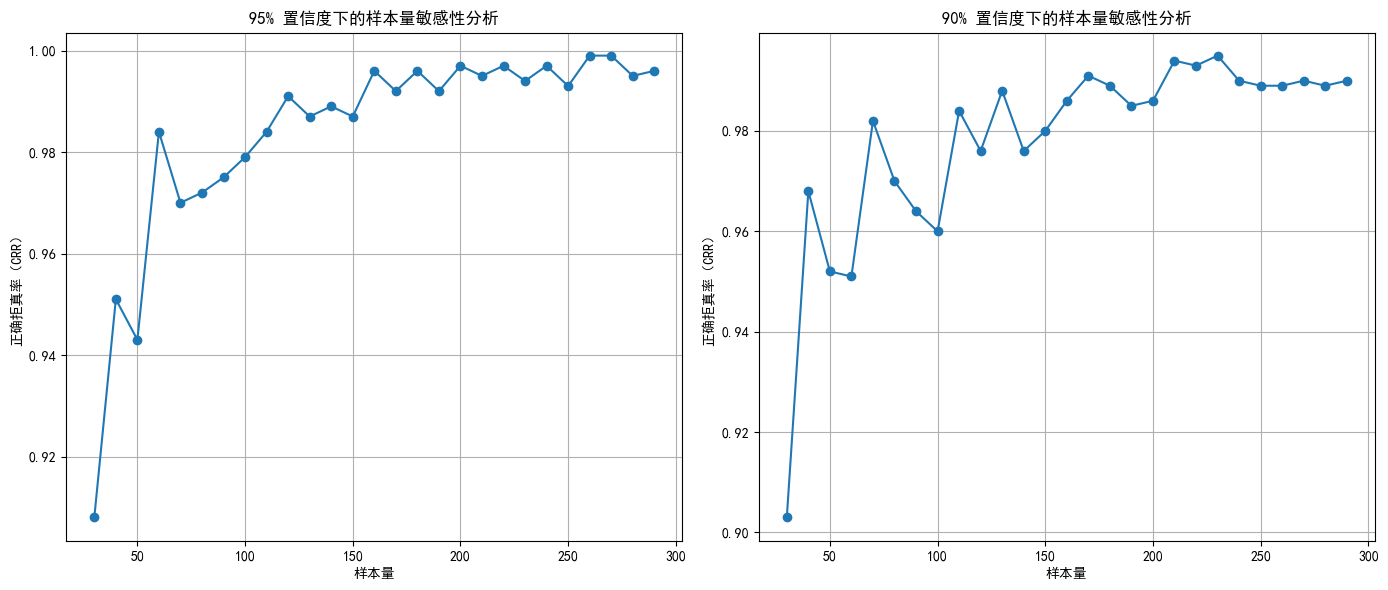

In [44]:
# 定义参数
p_nominal = 0.10  # 标称次品率
p_actual = 0.12   # 实际次品率
sample_sizes = np.arange(30, 300, 10)  # 样本大小范围
confidence_levels = [0.95, 0.90]  # 置信度
Z_values = [1.96, 1.645]  # 对应的Z值
error_margin = 0.05  # 误差范围

# 创建子图
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

for i, confidence_level in enumerate(confidence_levels):
    Z_alpha_2 = Z_values[i]
    crr_results = []  # 单因素灵敏度分析

    for n in sample_sizes:
        reject_count = 0  # 正确拒收计数

        # 模拟抽样检测
        for _ in range(1000):
            sample_defectives = np.random.binomial(n, p_actual)# 生成二项分布的随机数
            sample_rate = sample_defectives / n# 算p
            se = np.sqrt((sample_rate * (1 - sample_rate)) / n)# 算E标准误差
            upper_bound = sample_rate + Z_alpha_2 * se# 上置信限

            if upper_bound > p_nominal:  # 拒收条件
                reject_count += 1

        # 计算正确拒收率
        crr = reject_count / 1000
        crr_results.append((n, crr))

    # 绘制图形
    axs[i].plot([n for n, _ in crr_results], [crr for _, crr in crr_results], marker='o')
    axs[i].set_xlabel('样本量')
    axs[i].set_ylabel('正确拒真率（CRR）')
    axs[i].set_title(f'{int(confidence_level * 100)}% 置信度下的样本量敏感性分析')
    axs[i].grid(True)

plt.tight_layout()
plt.show()